In [1]:
import os

# detect gpus
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(os.environ["CUDA_VISIBLE_DEVICES"])

0


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import json

### 1. Data preprocessing

In [3]:
users = pd.read_csv('../data/users.csv')
games = pd.read_csv('../data/games.csv')

games_metadata_list = []
with open('../data/games_metadata.json', 'r') as f:
    for line in f:
        games_metadata_list.append(json.loads(line))
games_metadata = pd.json_normalize(games_metadata_list)

##### games_metadata.json

In [4]:
# 检查 description 列为空字符串的情况
empty_description = games_metadata[games_metadata['description'] == '']
print(f"Number of empty descriptions: {len(empty_description)}")

# 检查 tags 列为空列表的情况
empty_tags = games_metadata[games_metadata['tags'].apply(lambda x: len(x) == 0)]
print(f"Number of empty tags: {len(empty_tags)}")

# 打印出空 description 和空 tags 的行
print("Rows with empty descriptions:")
print(empty_description)

print("Rows with empty tags:")
print(empty_tags)

Number of empty descriptions: 10373
Number of empty tags: 1244
Rows with empty descriptions:
        app_id description                                               tags
1        22364                                                       [Action]
7       271850              [Strategy, Simulation, Action, RTS, World War II]
18      245950              [Action, RPG, FPS, Co-op, Shooter, Action RPG,...
21      305181                                            [Adventure, Action]
30      458790                          [Adventure, Soundtrack, Visual Novel]
...        ...         ...                                                ...
50866  2362300                                                             []
50867  2296380                                                             []
50868  1272080                                                             []
50869  1402110                                                             []
50871  2488510                                   

In [5]:
# drop rows with empty tags and empty descriptions
games_metadata = games_metadata[games_metadata['description'] != '']
print(f"Number of games after dropping empty descriptions: {len(games_metadata)}")
games_metadata = games_metadata[games_metadata['tags'].apply(lambda x: len(x) > 0)]
print(f"Number of games after dropping empty tags: {len(games_metadata)}")
games_metadata = games_metadata.reset_index(drop=True)

all_tags = list(set(tag for tags in games_metadata['tags'] for tag in tags))
tag_encoder = LabelEncoder()
tag_encoder.fit(all_tags)

def encode_tags(tags_list):
    return tag_encoder.transform(tags_list)

games_metadata['tags_enc'] = games_metadata['tags'].apply(encode_tags)
num_tags = len(tag_encoder.classes_)
print(f"Number of unique tags: {num_tags}")

# drop columns that are not needed
games_metadata = games_metadata.drop(columns=['tags', 'description'])

Number of games after dropping empty descriptions: 40499
Number of games after dropping empty tags: 40484
Number of unique tags: 441


In [6]:
games_metadata

,app_id,tags_enc
0,13500,"[17, 23, 271, 384, 170, 341, 283, 391, 38, 77,..."
1,113020,"[79, 363, 192, 177, 210, 367, 266, 392, 17, 24..."
2,226560,"[439, 23, 374, 17, 384, 267, 167, 185, 341, 24..."
3,249050,"[318, 367, 395, 282, 192, 301, 329, 123, 23, 2..."
4,250180,"[31, 77, 17, 79, 338, 314, 210, 335, 3, 266, 1..."
...,...,...
40479,2515240,"[185, 38, 295, 23, 426, 150, 308, 105, 7, 167,..."
40480,2455060,"[301, 192, 262, 20, 148, 17, 173, 23, 7, 320, ..."
40481,1138640,"[127, 208, 75, 191, 112, 58, 327, 221, 96, 44,..."
40482,1687000,"[338, 49, 327, 223, 208, 301, 3, 366, 245, 267..."


#### games.csv

In [7]:
# check unique values in rating column
print(games['rating'].unique())

['Very Positive' 'Positive' 'Mixed' 'Mostly Positive'
 'Overwhelmingly Positive' 'Negative' 'Mostly Negative'
 'Overwhelmingly Negative' 'Very Negative']


In [8]:
# map rating to numerical values ['Very Positive' 'Positive' 'Mixed' 'Mostly Positive' 'Overwhelmingly Positive' 'Negative' 'Mostly Negative' 'Overwhelmingly Negative' 'Very Negative']
rating_map = {
    'Overwhelmingly Positive': 8,
    'Very Positive': 7,
    'Mostly Positive': 6,
    'Positive': 5,
    'Mixed': 4,
    'Mostly Negative': 3,
    'Negative': 2,
    'Overwhelmingly Negative': 1,
    'Very Negative': 0
}

games['rating'] = games['rating'].map(rating_map)
games['rating'].unique()

array([7, 5, 4, 6, 8, 2, 3, 1, 0], dtype=int64)

In [9]:
from datetime import datetime

games['app_id'] = games['app_id'].astype(int)

games['date_release'] = pd.to_datetime(games['date_release'])
current_date = datetime.now()
games['release_days'] = (current_date - games['date_release']).dt.days
games.drop('date_release', axis=1, inplace=True) 

games['win'] = games['win'].astype(int)
games['mac'] = games['mac'].astype(int)
games['linux'] = games['linux'].astype(int)

games['positive_ratio'] = games['positive_ratio'].astype(float)
games['user_reviews'] = games['user_reviews'].astype(int)

games['price_final'] = games['price_final'].astype(float)
games['price_original'] = games['price_original'].astype(float)
games['discount'] = games['discount'].astype(float)

games['steam_deck'] = games['steam_deck'].astype(int)

print(games.head())

   app_id                              title  win  mac  linux  rating  \
0   13500  Prince of Persia: Warrior Within™    1    0      0       7   
1   22364            BRINK: Agents of Change    1    0      0       5   
2  113020       Monaco: What's Yours Is Mine    1    1      1       7   
3  226560                 Escape Dead Island    1    0      0       4   
4  249050            Dungeon of the ENDLESS™    1    1      0       7   

   positive_ratio  user_reviews  price_final  price_original  discount  \
0            84.0          2199         9.99            9.99       0.0   
1            85.0            21         2.99            2.99       0.0   
2            92.0          3722        14.99           14.99       0.0   
3            61.0           873        14.99           14.99       0.0   
4            88.0          8784        11.99           11.99       0.0   

   steam_deck  release_days  
0           1          5799  
1           1          4814  
2           1          418

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pandas as pd


# 1. 使用TF-IDF来提取标题中的特征
vectorizer = TfidfVectorizer(max_features=300)  # 限制最大特征数为300，以控制稀疏度
X_tfidf = vectorizer.fit_transform(games['title'])

# 2. 使用TruncatedSVD对TF-IDF矩阵进行降维，减少稀疏度
svd = TruncatedSVD(n_components=50)  # 降维到50维
X_reduced = svd.fit_transform(X_tfidf)

# 将降维后的结果加入到数据集中
games['title_vector'] = list(X_reduced)

# 检查处理后的结果
print(games[['title', 'title_vector']].head())
games.drop('title', axis=1, inplace=True)


                               title  \
0  Prince of Persia: Warrior Within™   
1            BRINK: Agents of Change   
2       Monaco: What's Yours Is Mine   
3                 Escape Dead Island   
4            Dungeon of the ENDLESS™   

                                        title_vector  
0  [0.16867213822580915, 0.37316500304606465, -0....  
1  [0.40562555976493103, 0.9066350281957338, -0.0...  
2  [0.005065993196183791, -0.002982083241901832, ...  
3  [0.011830615410017746, -0.0006498225633024842,...  
4  [0.3920505430130233, 0.1704900978892519, -0.02...  


In [11]:
games

,app_id,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,release_days,title_vector
0,13500,1,0,0,7,84.0,2199,9.99,9.99,0.0,1,5799,"[0.16867213822580915, 0.37316500304606465, -0...."
1,22364,1,0,0,5,85.0,21,2.99,2.99,0.0,1,4814,"[0.40562555976493103, 0.9066350281957338, -0.0..."
2,113020,1,1,1,7,92.0,3722,14.99,14.99,0.0,1,4184,"[0.005065993196183791, -0.002982083241901832, ..."
3,226560,1,0,0,4,61.0,873,14.99,14.99,0.0,1,3611,"[0.011830615410017746, -0.0006498225633024842,..."
4,249050,1,1,0,7,88.0,8784,11.99,11.99,0.0,1,3633,"[0.3920505430130233, 0.1704900978892519, -0.02..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50867,2296380,1,0,0,7,96.0,101,22.00,0.00,0.0,1,375,"[0.23448365566506219, -0.10779078404801798, 0...."
50868,1272080,1,0,0,3,38.0,29458,40.00,0.00,0.0,1,382,"[0.002217280937889822, -0.0010282516117298176,..."
50869,1402110,1,0,0,7,89.0,1128,30.00,0.00,0.0,1,392,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
50870,2272250,1,0,0,7,95.0,82,17.00,0.00,0.0,1,354,"[0.0016944786540787858, -0.0002396260557621271..."


#### recommendations.csv

In [12]:
recommendations = pd.read_csv('../data/recommendations.csv')
recommendations

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,51580,0
1,304390,4,0,2017-02-17,False,11.5,2586,1
2,1085660,2,0,2019-11-17,True,336.5,253880,2
3,703080,0,0,2022-09-23,True,27.4,259432,3
4,526870,0,0,2021-01-10,True,7.9,23869,4
...,...,...,...,...,...,...,...,...
41154789,633230,0,0,2021-02-15,True,41.0,1606890,41154789
41154790,758870,8,0,2019-07-18,False,8.0,1786254,41154790
41154791,696170,3,10,2018-03-26,False,2.0,6370324,41154791
41154792,696170,0,0,2018-06-11,True,4.0,1044289,41154792


In [13]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

recommendations['date'] = pd.to_datetime(recommendations['date'], format='%Y-%m-%d')
recommendations['year'] = recommendations['date'].dt.year
recommendations['month'] = recommendations['date'].dt.month
recommendations['day'] = recommendations['date'].dt.day
recommendations['weekday'] = recommendations['date'].dt.weekday  # 周一为0，周日为6

recommendations.drop(columns=['date'], inplace=True)

recommendations.loc[:, 'helpful'] = recommendations['helpful'].astype(int)
recommendations.loc[:, 'funny'] = recommendations['funny'].astype(int)
recommendations.loc[:, 'hours'] = recommendations['hours'].astype(float)
# delete hours <= 2.0
recommendations = recommendations[recommendations['hours'] > 2.0]

recommendations.loc[:, 'is_recommended'] = recommendations['is_recommended'].map({True: 1, False: 0})

recommendations = recommendations.drop(columns=['review_id'])

print(recommendations.head())


C:\Users\Jinuo\AppData\Local\Temp\ipykernel_14324\959098349.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 0 1 ... 0 1 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  recommendations.loc[:, 'is_recommended'] = recommendations['is_recommended'].map({True: 1, False: 0})


    app_id  helpful  funny  is_recommended  hours  user_id  year  month  day  \
0   975370        0      0               1   36.3    51580  2022     12   12   
1   304390        4      0               0   11.5     2586  2017      2   17   
2  1085660        2      0               1  336.5   253880  2019     11   17   
3   703080        0      0               1   27.4   259432  2022      9   23   
4   526870        0      0               1    7.9    23869  2021      1   10   

   weekday  
0        0  
1        4  
2        6  
3        4  
4        6  


In [14]:
recommendations

,app_id,helpful,funny,is_recommended,hours,user_id,year,month,day,weekday
0,975370,0,0,1,36.3,51580,2022,12,12,0
1,304390,4,0,0,11.5,2586,2017,2,17,4
2,1085660,2,0,1,336.5,253880,2019,11,17,6
3,703080,0,0,1,27.4,259432,2022,9,23,4
4,526870,0,0,1,7.9,23869,2021,1,10,6
...,...,...,...,...,...,...,...,...,...,...
41154788,391220,0,0,1,18.0,9958247,2021,4,28,2
41154789,633230,0,0,1,41.0,1606890,2021,2,15,0
41154790,758870,8,0,0,8.0,1786254,2019,7,18,3
41154792,696170,0,0,1,4.0,1044289,2018,6,11,0


In [15]:
# recommendations.to_csv('../data/processed/preprocessed_recommendations.csv', index=False)

#### users.csv

In [16]:
users

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1
2,8762579,329,4
3,4820647,176,4
4,5167327,98,2
...,...,...,...
14306059,5047430,6,0
14306060,5048153,0,0
14306061,5059205,31,0
14306062,5074363,0,0


In [17]:
# check how many users have 0 reviews(in recommendations.csv)
users_with_reviews = recommendations['user_id'].unique()
users_without_reviews = users[~users['user_id'].isin(users_with_reviews)]
print(f"Number of users without reviews: {len(users_without_reviews)}")

# check how many users have 0 games
# only look at products column that <= 0 in users.csv
users_with_games = users[users['products'] > 0]
users_without_games = users[~users['user_id'].isin(users_with_games['user_id'])]
print(f"Number of users without games: {len(users_without_games)}")

Number of users without reviews: 1051082
Number of users without games: 139318


In [18]:
# drop users without reviews and games
users = users[users['user_id'].isin(users_with_reviews)]
users = users[users['user_id'].isin(users_with_games['user_id'])]
users = users.reset_index(drop=True)
users

,user_id,products,reviews
0,14020781,156,1
1,8762579,329,4
2,4820647,176,4
3,5167327,98,2
4,5664667,145,5
...,...,...,...
13139325,4897585,54,2
13139326,4898597,7,1
13139327,4902361,7,1
13139328,4902380,9,1


#### merge

In [19]:
games_full = pd.merge(games, games_metadata, on='app_id', how='inner')

data = pd.merge(recommendations, games_full, on='app_id', how='inner')

data = pd.merge(data, users, on='user_id', how='inner')

In [20]:
# print first row in full text
pd.set_option('display.max_columns', None)
# make sure column content(such as list) are also fully displayed
pd.set_option('display.max_colwidth', None)
print(data.head(1))
# print type of each column
print(data.dtypes)

    app_id  helpful  funny  is_recommended  hours  user_id  year  month  day  \
0  1544020       18      2               0    9.1  9254726  2022     12    2   

   weekday  win  mac  linux  rating  positive_ratio  user_reviews  \
0        4    1    0      0       4            62.0         21737   

   price_final  price_original  discount  steam_deck  release_days  \
0        59.99           59.99       0.0           1           676   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [21]:
# check detailed type of tags_enc and title_vector
print(type(data['tags_enc'][0]))
print(type(data['title_vector'][0]))

# # convert tags_enc and title_vector to list
# data['tags_enc'] = data['tags_enc'].apply(lambda x: list(x))
# data['title_vector'] = data['title_vector'].apply(lambda x: list(x))

# # check detailed type of tags_enc and title_vector
# print(type(data['tags_enc'][0]))
# print(type(data['title_vector'][0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [22]:
# check if there are any missing values
print(data.isnull().sum())

app_id            0
helpful           0
funny             0
is_recommended    0
hours             0
user_id           0
year              0
month             0
day               0
weekday           0
win               0
mac               0
linux             0
rating            0
positive_ratio    0
user_reviews      0
price_final       0
price_original    0
discount          0
steam_deck        0
release_days      0
title_vector      0
tags_enc          0
products          0
reviews           0
dtype: int64


In [23]:
# save the processed full dataset
# data.to_csv('../data/processed/processed_full.csv', index=False)

### 2. Feature Engineering

In [24]:
# shut down full text display
pd.reset_option('display.max_columns')
pd.reset_option('display.max_colwidth')
data.head(1)

,app_id,helpful,funny,is_recommended,hours,user_id,year,month,day,weekday,...,user_reviews,price_final,price_original,discount,steam_deck,release_days,title_vector,tags_enc,products,reviews
0,1544020,18,2,0,9.1,9254726,2022,12,2,4,...,21737,59.99,59.99,0.0,1,676,"[0.9077150941121978, -0.4108130930532424, -0.0...","[185, 329, 375, 385, 356, 335, 21, 384, 298, 7...",724,34


#### Numerical datasets

In [25]:
feature_columns = ['user_id', 'app_id', 'helpful', 'funny', 'hours', 'year', 'month', 'day', 'weekday',
                   'win', 'mac', 'linux', 'rating', 'positive_ratio', 'user_reviews', 'price_final',
                   'price_original', 'discount', 'steam_deck', 'release_days', 'products', 'reviews']

In [26]:
from sklearn.model_selection import train_test_split

# 将 numpy 数组展开并添加到特征列中
title_vector_array = np.stack(data['title_vector'].values)
# 找到最长的 tags_enc 数组长度
max_len = max(len(x) for x in data['tags_enc'].values)
# 填充 tags_enc 数组
tags_enc_array = np.array([np.pad(x, (0, max_len - len(x)), 'constant') for x in data['tags_enc'].values])

# 合并所有特征
X_numeric = data[feature_columns].values
X = np.hstack((X_numeric, title_vector_array, tags_enc_array))

# 目标变量
y = data['is_recommended'].values

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Time series datasets

In [27]:
data.sort_values(by=['user_id', 'year', 'month', 'day'], inplace=True)

In [7]:
# 设置序列长度和填充值
sequence_length = 3
fill_value = -1

In [32]:
import numpy as np
import pandas as pd
from tqdm import tqdm


# 预处理 'tags_enc' 列，填充为相同的长度
max_len = max(len(tags) for tags in data['tags_enc'])
tags_enc_padded = np.array([
    np.pad(tags, (0, max_len - len(tags)), 'constant', constant_values=fill_value)
    for tags in data['tags_enc']
])
data['tags_enc_padded'] = list(tags_enc_padded)

# 扩展特征列，包含填充后的 'tags_enc_padded'
feature_columns_extended = feature_columns.copy()
feature_columns_extended.append('tags_enc_padded')

# 将特征转换为 NumPy 数组
X_numeric = data[feature_columns].values
tags_enc_array = np.vstack(data['tags_enc_padded'].values)
X_all = np.hstack([X_numeric, tags_enc_array])

# 获取标签
y_all = data['is_recommended'].values


In [33]:
# 定义块大小，根据内存情况进行调整
chunk_size = 100000

# 计算序列总数和块数
num_samples = len(data)
num_sequences = num_samples - sequence_length + 1
num_chunks = (num_sequences + chunk_size - 1) // chunk_size  # 向上取整

X_sequences_list = []
y_sequences_list = []

# 使用 tqdm 显示进度条，遍历每个块
for chunk_index in tqdm(range(num_chunks), desc="Processing chunks"):
    start_seq = chunk_index * chunk_size
    end_seq = min(start_seq + chunk_size, num_sequences)

    # 检查是否有足够的数据创建序列
    if end_seq <= start_seq:
        continue

    # 提取当前块的数据
    X_chunk = X_all[start_seq:end_seq + sequence_length - 1]
    y_chunk = y_all[start_seq:end_seq + sequence_length - 1]

    # 使用矢量化操作创建序列
    num_chunk_sequences = len(X_chunk) - sequence_length + 1
    if num_chunk_sequences <= 0:
        continue

    # 创建特征序列
    X_chunk_sequences = np.lib.stride_tricks.sliding_window_view(
        X_chunk, window_shape=(sequence_length, X_chunk.shape[1])
    )[:, 0, :, :]

    # 创建标签序列
    y_chunk_sequences = y_chunk[sequence_length - 1:]

    # 添加到列表中
    X_sequences_list.append(X_chunk_sequences)
    y_sequences_list.append(y_chunk_sequences)

# 合并所有块的数据
X_sequences = np.concatenate(X_sequences_list, axis=0)
y_sequences = np.concatenate(y_sequences_list, axis=0)

# 检查是否有剩余的数据需要填充
remaining_samples = num_samples - (num_sequences + sequence_length - 1)
if remaining_samples > 0:
    X_padding = np.full((sequence_length - remaining_samples, X_all.shape[1]), fill_value)
    X_remaining = np.vstack([X_padding, X_all[-remaining_samples:]])
    X_sequences = np.vstack([X_sequences, [X_remaining]])
    y_sequences = np.hstack([y_sequences, y_all[-1]])

Processing chunks: 100%|██████████| 170/170 [00:00<00:00, 82014.23it/s]


#### Temp stop

In [35]:
# save X_sequences and y_sequences
np.save('../data/processed/X_sequences.npy', X_sequences)
np.save('../data/processed/y_sequences.npy', y_sequences)

#### Continue

In [4]:
# read
X_sequences = np.load('../data/processed/X_sequences.npy')
y_sequences = np.load('../data/processed/y_sequences.npy')

In [5]:
# 展开数据进行标准化
num_features = X_sequences.shape[2]
X_reshaped = X_sequences.reshape(-1, num_features)
# 在读取数据或创建数组时，指定数据类型为 float32
X_reshaped = X_reshaped.astype(np.float32)

In [8]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# 假设您已经有 X_reshaped 和 valid_indices

# 设置批次大小，根据系统内存情况进行调整
batch_size = 100000  # 可以根据实际情况调整

num_samples = X_reshaped.shape[0]
num_batches = (num_samples + batch_size - 1) // batch_size  # 向上取整

# 创建一个与 X_reshaped 形状相同的数组，用于存储标准化后的数据
# 为了节省内存，我们可以将结果写入文件或逐步处理
# 这里我们假设逐步处理，避免一次性创建大数组

# 初始化一个列表来存储处理后的批次数据
processed_batches = []

for batch_index in range(num_batches):
    start_idx = batch_index * batch_size
    end_idx = min(start_idx + batch_size, num_samples)
    
    # 提取当前批次的数据
    X_batch = X_reshaped[start_idx:end_idx]
    valid_mask = ~(X_batch == fill_value).all(axis=1)
    
    # 对有效数据进行标准化
    X_valid = X_batch[valid_mask]
    if X_valid.size > 0:
        scaler = StandardScaler()
        X_scaled_valid = scaler.fit_transform(X_valid)
        
        # 将标准化后的数据放回原数组的位置
        X_batch_scaled = np.full_like(X_batch, fill_value, dtype=np.float32)
        X_batch_scaled[valid_mask] = X_scaled_valid.astype(np.float32)
    else:
        # 如果批次中全是填充值
        X_batch_scaled = X_batch.astype(np.float32)
    
    # 将处理后的批次数据添加到列表中
    processed_batches.append(X_batch_scaled)
    
    print(f"Processed batch {batch_index + 1}/{num_batches}")

# 将所有批次的数据合并
X_scaled = np.concatenate(processed_batches, axis=0)

Processed batch 1/509
Processed batch 2/509
Processed batch 3/509
Processed batch 4/509
Processed batch 5/509
Processed batch 6/509
Processed batch 7/509
Processed batch 8/509
Processed batch 9/509
Processed batch 10/509
Processed batch 11/509
Processed batch 12/509
Processed batch 13/509
Processed batch 14/509
Processed batch 15/509
Processed batch 16/509
Processed batch 17/509
Processed batch 18/509
Processed batch 19/509
Processed batch 20/509
Processed batch 21/509
Processed batch 22/509
Processed batch 23/509
Processed batch 24/509
Processed batch 25/509
Processed batch 26/509
Processed batch 27/509
Processed batch 28/509
Processed batch 29/509
Processed batch 30/509
Processed batch 31/509
Processed batch 32/509
Processed batch 33/509
Processed batch 34/509
Processed batch 35/509
Processed batch 36/509
Processed batch 37/509
Processed batch 38/509
Processed batch 39/509
Processed batch 40/509
Processed batch 41/509
Processed batch 42/509
Processed batch 43/509
Processed batch 44/5

In [9]:
X_sequences_scaled = X_scaled.reshape(-1, sequence_length, num_features)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sequences_scaled, y_sequences, test_size=0.2, random_state=42
)

In [11]:
# print first row of X_train
print(X_train[0])

[[ 0.7723282  -0.00619634 -0.10650123 -0.05550704 -0.27581406  0.20724764
  -1.0555013  -1.3467779  -0.5710288   0.01643389 -0.7876907   1.5546869
  -0.65764135 -0.83394897 -0.17379154  0.75731647  0.65507686 -0.3227733
   0.01975227 -0.73886824  0.20178896  0.83868164  0.72924596  1.2864897
   0.8844647   0.3940292   1.2624168   1.4658484  -1.611428    1.0760235
  -0.5897686   0.6320884   1.5732908  -0.06259757 -0.56596094 -0.6164154
   1.0930051   0.98356324  0.4178425  -0.37860915  1.5752643   1.8394626 ]
 [ 0.7723282  -0.17581646 -0.10650123 -0.05550704 -0.42026     0.20724764
  -0.77503425  1.4856955  -0.06500845  0.01643389  1.2695339   1.5546869
  -0.65764135 -0.83394897 -0.5130937   0.07761183 -0.01423255 -0.3227733
   0.01975227 -0.5318045   0.20178896  0.83868164  1.5494604   0.63941675
   1.286157   -0.6390127  -1.0760603   1.2725003   0.6997058   0.9140278
  -1.3283131   1.5467029   1.2822816   1.518349    0.963166   -1.3942175
   1.6818678   1.5798521   0.891671    1.47200

In [12]:
# save train and test data
np.save('../data/train/timeSeries/X_train.npy', X_train)
np.save('../data/test/timeSeries/X_test.npy', X_test)
np.save('../data/train/timeSeries/y_train.npy', y_train)
np.save('../data/test/timeSeries/y_test.npy', y_test)

### 3. Model training

In [3]:
# read train and test data
X_train = np.load('../data/train/timeSeries/X_train.npy')
X_test = np.load('../data/test/timeSeries/X_test.npy')
y_train = np.load('../data/train/timeSeries/y_train.npy')
y_test = np.load('../data/test/timeSeries/y_test.npy')

In [4]:
# check the first row of X_train original data
print(X_train[0])

[[ 0.7723282  -0.00619634 -0.10650123 -0.05550704 -0.27581406  0.20724764
  -1.0555013  -1.3467779  -0.5710288   0.01643389 -0.7876907   1.5546869
  -0.65764135 -0.83394897 -0.17379154  0.75731647  0.65507686 -0.3227733
   0.01975227 -0.73886824  0.20178896  0.83868164  0.72924596  1.2864897
   0.8844647   0.3940292   1.2624168   1.4658484  -1.611428    1.0760235
  -0.5897686   0.6320884   1.5732908  -0.06259757 -0.56596094 -0.6164154
   1.0930051   0.98356324  0.4178425  -0.37860915  1.5752643   1.8394626 ]
 [ 0.7723282  -0.17581646 -0.10650123 -0.05550704 -0.42026     0.20724764
  -0.77503425  1.4856955  -0.06500845  0.01643389  1.2695339   1.5546869
  -0.65764135 -0.83394897 -0.5130937   0.07761183 -0.01423255 -0.3227733
   0.01975227 -0.5318045   0.20178896  0.83868164  1.5494604   0.63941675
   1.286157   -0.6390127  -1.0760603   1.2725003   0.6997058   0.9140278
  -1.3283131   1.5467029   1.2822816   1.518349    0.963166   -1.3942175
   1.6818678   1.5798521   0.891671    1.47200

#### Only needed for numerical datasets

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# check again after scaling
print(X_train[0])

[ 5.86144690e-01 -6.05450079e-01 -9.13440240e-02 -4.68720280e-02
  4.27310751e-01  7.30503193e-01 -2.53134537e-01  1.37850369e+00
 -1.06351936e+00  1.29023165e-02  1.23677621e+00  1.48536274e+00
  2.25564676e-01  4.87131358e-01  8.35271665e+00 -1.14038260e+00
 -1.21438255e+00 -3.19607298e-01  1.92575363e-02 -1.73346051e-01
 -3.36142412e-01 -2.07073786e-01 -4.40735413e-01 -1.46182195e-01
 -1.21424156e-01 -1.55078383e-01 -8.30348582e-03 -1.60364621e-01
 -1.32021271e-01 -1.92662417e-01 -1.91871986e-01 -2.28564512e-01
 -4.95732049e-02 -1.49748348e-02 -8.37291853e-02 -8.63709244e-02
 -2.09999108e-02 -1.12932753e-01 -7.01794547e-02 -1.21949498e-01
 -5.55791920e-02 -4.70676753e-02 -1.44020134e-01 -1.04215500e-01
  1.33354404e-01  7.78485506e-02 -1.07414871e-02 -3.60643419e-02
  1.90827085e-02 -8.73269168e-02 -1.15284837e-01  8.30226474e-03
 -1.16478862e-02 -4.96531054e-02 -1.16183149e-01  4.50318381e-02
  1.94609584e-02 -1.13900858e-01  1.83505982e-02 -1.04056432e-02
 -1.11259628e-01 -1.32998

#### Baseline1

In [5]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

##### Baseline1 training

In [9]:
# training!
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('../model/baseline1.h5', save_best_only=True, monitor='val_loss')

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=5,
                    batch_size=256,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/5
52970/52970 [==============================] - 142s 3ms/step - loss: 0.2987 - accuracy: 0.8894 - val_loss: 0.2962 - val_accuracy: 0.8916
Epoch 2/5
52970/52970 [==============================] - 142s 3ms/step - loss: 0.2924 - accuracy: 0.8910 - val_loss: 0.2936 - val_accuracy: 0.8919
Epoch 3/5
52970/52970 [==============================] - 139s 3ms/step - loss: 0.2907 - accuracy: 0.8914 - val_loss: 0.2897 - val_accuracy: 0.8922
Epoch 4/5
52970/52970 [==============================] - 147s 3ms/step - loss: 0.2898 - accuracy: 0.8917 - val_loss: 0.2872 - val_accuracy: 0.8929
Epoch 5/5
52970/52970 [==============================] - 140s 3ms/step - loss: 0.2892 - accuracy: 0.8919 - val_loss: 0.2899 - val_accuracy: 0.8928


#### Baseline2

In [5]:
import tensorflow as tf
from keras.layers import Input, Dense, BatchNormalization, Dropout, Add, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping


def create_model(input_dim):
    inputs = Input(shape=(input_dim,))
    
    # 初始层
    x = Dense(512, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # 第一层残差块
    shortcut = x
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    # 第二层残差块，调整 shortcut 的维度
    shortcut = x
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    
    # 使用 Dense 层改变 shortcut 的维度
    shortcut = Dense(256)(shortcut)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    # 第三层残差块，继续调整 shortcut 的维度
    shortcut = x
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    
    shortcut = Dense(128)(shortcut)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    # 第四层残差块，继续调整 shortcut 的维度
    shortcut = x
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    
    shortcut = Dense(64)(shortcut)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    # 输出层
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    return model


model = create_model(X_train.shape[1])

In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 92)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          47616       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 512)         2048        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 512)          0           ['batch_normalization[0][0]']

In [7]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

batch_size = 512
epochs = 100

In [8]:
# check current device
a = tf.constant(1.0)
print("Device used for computation:", a.device)

Device used for computation: /job:localhost/replica:0/task:0/device:GPU:0


In [9]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)

model.save('../model/resnet_baseline2.h5')

Epoch 1/100
26485/26485 [==============================] - 217s 8ms/step - loss: 0.2952 - accuracy: 0.8899 - val_loss: 0.2843 - val_accuracy: 0.8932
Epoch 2/100
26485/26485 [==============================] - 209s 8ms/step - loss: 0.2859 - accuracy: 0.8927 - val_loss: 0.2815 - val_accuracy: 0.8941
Epoch 3/100
26485/26485 [==============================] - 206s 8ms/step - loss: 0.2836 - accuracy: 0.8934 - val_loss: 0.2798 - val_accuracy: 0.8946
Epoch 4/100
26485/26485 [==============================] - 210s 8ms/step - loss: 0.2822 - accuracy: 0.8938 - val_loss: 0.2789 - val_accuracy: 0.8950
Epoch 5/100
26485/26485 [==============================] - 209s 8ms/step - loss: 0.2813 - accuracy: 0.8941 - val_loss: 0.2782 - val_accuracy: 0.8951
Epoch 6/100
26485/26485 [==============================] - 210s 8ms/step - loss: 0.2806 - accuracy: 0.8944 - val_loss: 0.2780 - val_accuracy: 0.8954
Epoch 7/100
26485/26485 [==============================] - 208s 8ms/step - loss: 0.2800 - accuracy: 0.8945

#### LSTM

In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking

sequence_length = 3
fill_value = -1

model = Sequential()
model.add(Masking(mask_value=fill_value, input_shape=(sequence_length, X_train.shape[2])))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 3, 42)             0         
                                                                 
 lstm (LSTM)                 (None, 3, 256)            306176    
                                                                 
 dropout (Dropout)           (None, 3, 256)            0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [7]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('best_lstm_model.h5', save_best_only=True, monitor='val_loss')

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=2048,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
5297/5297 [==============================] - 87s 16ms/step - loss: 0.2985 - accuracy: 0.8892 - val_loss: 0.2905 - val_accuracy: 0.8913
Epoch 2/50
5297/5297 [==============================] - 127s 24ms/step - loss: 0.2908 - accuracy: 0.8913 - val_loss: 0.2860 - val_accuracy: 0.8926
Epoch 3/50
5297/5297 [==============================] - 135s 25ms/step - loss: 0.2876 - accuracy: 0.8922 - val_loss: 0.2842 - val_accuracy: 0.8931
Epoch 4/50
5297/5297 [==============================] - 88s 17ms/step - loss: 0.2857 - accuracy: 0.8927 - val_loss: 0.2823 - val_accuracy: 0.8938
Epoch 5/50
5297/5297 [==============================] - 91s 17ms/step - loss: 0.2844 - accuracy: 0.8931 - val_loss: 0.2817 - val_accuracy: 0.8939
Epoch 6/50
5297/5297 [==============================] - 76s 14ms/step - loss: 0.2834 - accuracy: 0.8934 - val_loss: 0.2810 - val_accuracy: 0.8941
Epoch 7/50
5297/5297 [==============================] - 103s 19ms/step - loss: 0.2825 - accuracy: 0.8937 - val_loss: 0.280

### 4. Model Evaluation

d:\Miniconda\envs\CV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Miniconda\envs\CV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Miniconda\envs\CV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Miniconda\envs\CV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Miniconda\envs\CV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  fig.canvas.prin

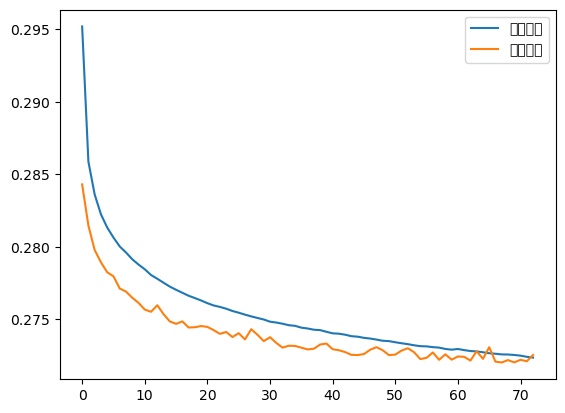

d:\Miniconda\envs\CV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Miniconda\envs\CV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Miniconda\envs\CV\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


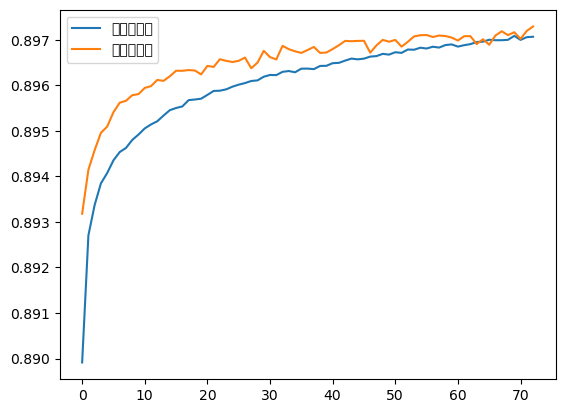

In [10]:
import matplotlib.pyplot as plt


plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [12]:
# load best model
from keras.models import load_model

best_model = load_model('../model/resnet_baseline2.h5')

loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"val loss: {loss}")
print(f"val acc: {accuracy}")

105940/105940 [==============================] - 223s 2ms/step - loss: 0.2720 - accuracy: 0.8972
测试集损失：0.2720302939414978
测试集准确率：0.8971896767616272


In [13]:
# confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
print(cm)

105940/105940 [==============================] - 182s 2ms/step
[[  91353  304332]
 [  44202 2950182]]


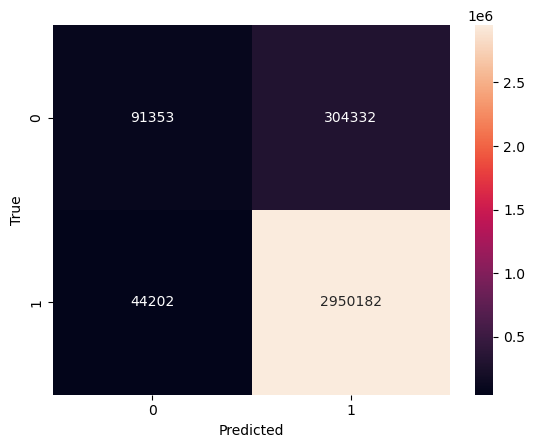

              precision    recall  f1-score   support

           0       0.67      0.23      0.34    395685
           1       0.91      0.99      0.94   2994384

    accuracy                           0.90   3390069
   macro avg       0.79      0.61      0.64   3390069
weighted avg       0.88      0.90      0.87   3390069



In [15]:
# plot cm
import seaborn as sns

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

### 5. Recommendation function